# Mini-projet Optimisation
# Charge d'une flotte de véhicules électriques

### 1) Fonction objectif du problème

On cherche à réduire à minimiser le coût électrique de recharge défini par 
$ f(P_1,P_2,...,P_N) = \sum_{i=1}^{N} \left( \displaystyle \int_{t_0}^{t_f} P_i.C_p.\mathbb{1}_{heures pleines} \mathrm{dt} + \displaystyle \int_{t_0}^{t_f} P_i.C_c.\mathbb{1}_{heures creuses} \mathrm{dt} \right)$

avec $P_i : [t_0, t_f] -> \mathbb{R}$ qu'on supposera bornées, $C_p$ et $C_c$ les prix du kWh pendant les heures pleines et pendant les heures creuses.

### 2) Modèle dynamique de charges d'un véhicule

On a en notant $c_i$ l'état de charge relatif de la voiture i, $E_i$ l'énergie que stocke la voiture i et $E_{max}$ l'énergie maximale que peut stocker chaque voiture, on a 
$\large{c_i(t) = \frac{E_i(t)}{E_{max}} = \frac{1}{E_{max}} \displaystyle \int_{t_0}^{t} P_i(t') \mathrm{dt'} + c_i(t_0)}$

Si en notant $U_{sec}$ la tension du secteur c'est à dire aux bornes de chaque prise, on a $E_{max} = U_{sec} . Q_{max}$ et $P_i(t) = U_{sec} . i_i(t)$

d'où 
$\large{c_i(t) = \displaystyle \int_{t_0}^{t} \frac{i_i(t')}{Q_{max}} \mathrm{dt'}} + c_i(t_0)$

### 3) Identificaton du modèle

On cherche à identifier $Q_{max}$
On va dériver la relation précédente qui nous donne:
$\large{c_i'(t) = \frac{i_i(t)}{Q_{max}}}$

Nous allons donc déterminer approcher la dérivée de l'état de charge relatif et analyser en fonction du courant entrant pour déterminer $Q_{max}$

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df_donnees = pd.read_csv("donnees-projet-gr1.txt",sep = "\t")
df_donnees.head()

,temps,intensite,etat
0,0.000000,0.005755,0.626524
1,1.005016,0.018529,0.631323
2,2.008215,-0.022398,0.629266
3,3.018137,0.008812,0.631987
4,4.023168,0.003566,0.632518


,temps,intensite,etat,dqrel/dt
0,0.000000,0.005755,0.626524,0.004775
1,1.005016,0.018529,0.631323,-0.002050
2,2.008215,-0.022398,0.629266,0.002694
3,3.018137,0.008812,0.631987,0.000529
4,4.023168,0.003566,0.632518,0.000360


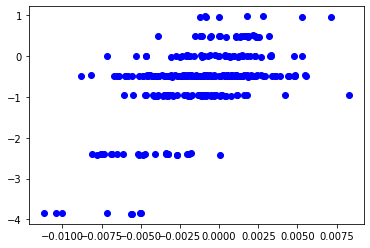

In [8]:
#on derive l'etat de charge
C_prime = np.zeros(299)
C = np.array(df_donnees['etat'])
T = np.array(df_donnees['temps'])
for i in range(0,298):
    deltaT = T[i+1] - T[i]
    deltaC = C[i+1] - C[i]
    C_prime[i] = deltaC/deltaT    
C_prime[298]=C_prime[297]

#on trace c' en fonction de i
I = np.array(df_donnees['intensite'])
plt.plot(C_prime, I, 'bo');

#on rajoute au dataframe c'
df_donnees['dqrel/dt'] = C_prime
df_donnees.head()

On remarque que les données sont réparties de manière bruités : à (casi) une valeur de i correspondent plusieurs valeurs de c'
On va éliminer le bruit en moyennant par valeurs de i.

In [9]:
#regroupement par valeurs de I
intensite_groups = [-4, -3, -2, -1, -0.75, -0.25, 0.25, 0.75, 1] 

intensite_group_names = ['<-3A', '-3A<.<-2A', '-2A<.<-1A', '-1A<.<-0.75A', '-0.75A<.<-0.25A', '-0.25A<.<0.25A', '0.25A<.<0.75A', '>0.75A']

df_donnees['Intensite group'] = pd.cut(
    df_donnees['intensite'], bins=intensite_groups, labels=intensite_group_names)
df_donnees

,temps,intensite,etat,dqrel/dt,Intensite group
0,0.000000,0.005755,0.626524,0.004775,-0.25A<.<0.25A
1,1.005016,0.018529,0.631323,-0.002050,-0.25A<.<0.25A
2,2.008215,-0.022398,0.629266,0.002694,-0.25A<.<0.25A
3,3.018137,0.008812,0.631987,0.000529,-0.25A<.<0.25A
4,4.023168,0.003566,0.632518,0.000360,-0.25A<.<0.25A
...,...,...,...,...,...
294,295.401837,-0.962244,0.263155,-0.001355,-1A<.<-0.75A
295,296.407886,-0.962589,0.261792,-0.000957,-1A<.<-0.75A
296,297.413096,-0.986931,0.260830,-0.003322,-1A<.<-0.75A
297,298.418893,-0.956444,0.257489,-0.001184,-1A<.<-0.75A


Maintenant qu'on a regroupé par catégories de valeurs de i (choisies selon le premier graphique), on calcule la moyenne de l'intensité et de c' pour chaque catégories.

In [44]:
df_intensite = df_donnees.pivot_table('intensite', columns='Intensite group', aggfunc=np.mean)
I = np.array(df_intensite.T['intensite'][0:7])
I

array([-3.84973036e+00, -2.40560293e+00, -9.63347293e-01, -4.81853718e-01,
        3.01298411e-03,  4.82923727e-01,  9.63605114e-01])

In [45]:
df_dq = df_donnees.pivot_table('dqrel/dt', columns='Intensite group', aggfunc=np.mean)
dQreldt = np.array(df_dq.T['dqrel/dt'][0:7])
dQreldt

array([-0.00750355, -0.00471781, -0.0016157 , -0.00098683, -0.00019937,
        0.00084472,  0.00175787])

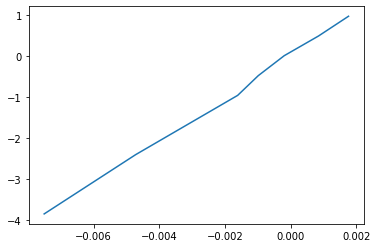

In [46]:
#On trace les valeurs moyennes de l'intensité en fonction des valeurs moyennes de c'

I = np.array([-3.84973,-2.405603,-0.963347,-0.481854,0.003013,0.482924,0.963605])
dQreldt = np.array([-0.007504,-0.004718,-0.001616,-0.000987,-0.000199,0.000845,0.001758])
plt.plot(dQreldt,I)
plt.show();

In [47]:
#on détermine Qmax à l'aide d'une régression linéaire
from statsmodels.regression.linear_model import OLS
model = OLS(dQreldt,I)
results = model.fit()
su = results.summary()
su

C:\anaconda\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              3879.
Date:                Tue, 14 Apr 2020   Prob (F-statistic):                    1.15e-09
Time:                        17:15:55   Log-Likelihood:                          52.298
No. Observations:                   7   AIC:                                     -102.6
Df Residuals:                       6   BIC:                                     -102.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0019   3.11e-05     62.279      0.000       0.002       0.002
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.691
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.629
Skew:                           1.392   Prob(JB):                        0.269
Kurtosis:                       4.124   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
Qmax = 1/0.0019

On remarque donc que pour que le modèle s'ajuste aux données, il faut `Qmax = 1/0.0019 C`. On est ravi puisqu'ici le coefficient r² est très proche de 1, ce qui conforte la modélisation linéaire.

### 4) Contraintes et problème de minimisation

cariables de décision : les Pi comme des fonctions en escalier donc des 2N-1 uplets
contraintes : 
    somme des puissances inferieure à Pmax et positive
    puissance entre Pmax et -Pmax
    (puissances toutes positives)
    c(tf) - c(t0) = int(P/Emax)
    0<=c<=1

Pour simplifier le problème, nous proposons de limiter les valeurs des fonctions Pi. En rangeant les temps t0i et tfi par ordre croissant, on obtient une suite strictement croissante $t_1 < t_2 < \dots < t_k$ avec k le nombre de date t0 et tf strictement différentes en comptant les dates de changement de tarifs horaires. On a en particulier $2 \leq k \leq 2N+1$(si on ne fait que 3 plages tarifaires au max comme une heures pleines, une heures creuses et une autre heures pleines).

Il suffit ensuite de remarquer que l'on peut sans perdre l'optimalité de la réponse prendre des Pi constants sur chaque intervalle $[t_i , t_{i+1}]$. En effet le paramètre important est son intégrale sur cet intervalle, et ça ne change pas de prendre donc la moyenne de Pi au lieu de Pi.

Ainsi on se ramène à une variable de décision sur les $(P_{ij})_{1 \leq i \leq N , 1 \leq j \leq k - 1}$ avec $\forall t \in [t_j,t_{j+1}]$, $P_i(t) = P_{ij}$

On peut dénombrer les contrainte suivantes :

$(1) \sum_{i=1}^{N} P_i - P_{max} \leq 0$
   
$(2) - \sum_{i=1}^{N} P_i \leq 0$
   
$(3) \| \sum_{i=1}^{N} P_i \| - P_{max} \leq 0$
  
$(4) \forall i, c_i(t_{fi}) - c_i(t_{0i}) = \displaystyle \int_{t_{0i}}^{t_{fi}} \frac{Pi(t)}{E_{max}} \mathrm(dt)$

$(5) \forall (t,i) , c_i(t)-1 \leq 0$ ou comme les Pi sont constants $\forall k, c_i(t_k) - 1 \leq 0$

$(6) \forall (t,i) , -c_i(t) \leq 0$ ou comme les Pi sont constants $\forall k, -c_i(t_k) \leq 0$

La fonction objectif du problème est :
$ f(P_1,P_2,...,P_N) = \sum_{i=1}^{N} \left( \displaystyle \int_{t_0}^{t_f} P_i.C_p.\mathbb{1}_{heures pleines} \mathrm{dt} + \displaystyle \int_{t_0}^{t_f} P_i.C_c.\mathbb{1}_{heures creuses} \mathrm{dt} \right)$

En notant C_j le coût du kWh sur l'intervalle de temps $[t_j,t_{j+1}]$ (fixe), on simplifie l'expression précédente en 
$f(P_{1,1}, \dots, P_{1,k-1}, \dots, P_{N,1}, \dots, P_{N,k-1}) = \sum_{i=1}^{N} \sum_{j=1}^{k-1} (P_{i,j} . C_j .(t_{j+1}-t_j))$